In [46]:
import kagglehub

path = kagglehub.dataset_download("alanvourch/tmdb-movies-daily-updates")

print("Path to dataset files:", path)

Path to dataset files: /home/lnxdread/.cache/kagglehub/datasets/alanvourch/tmdb-movies-daily-updates/versions/285


In [47]:
import pandas as pd

# Load CSV from './TMDB_all_movies.csv'
df = pd.read_csv(f"{path}/TMDB_all_movies.csv")

# Leave only the columns ['id', 'title', 'vote_average', 'status', 'release_date', 'budget', 'revenue', 'popularity', 'genres', 'cast', 'director', 'production_companies']
df = df[['id', 'title', 'vote_average', 'status', 'release_date', 'budget', 'revenue', 'popularity', 'genres', 'cast', 'director', 'production_companies']]

# Drop rows with NaN values
df = df.dropna()

# Save the result to './TMDB_all_movies_cleaned.csv'
df.to_csv('./TMDB_all_movies_cleaned.csv', index=False)

            id            title  vote_average    status release_date  \
56665    80035        The Watch           5.6  Released   2012-07-26   
33573    49797  I Saw the Devil           7.8  Released   2010-08-12   
408276  581389   Space Sweepers           7.1  Released   2021-02-05   
9000     15080   Only Yesterday           7.4  Released   1991-07-20   
3308      5924         Papillon           7.8  Released   1973-12-16   

            budget     revenue  popularity                           genres  \
56665   68000000.0  68267862.0      29.998  Comedy, Action, Science Fiction   
33573    6000000.0  12966357.0      29.992                 Thriller, Horror   
408276  21000000.0     24571.0      29.992  Drama, Fantasy, Science Fiction   
9000           0.0    473110.0      29.989        Animation, Drama, Romance   
3308    12000000.0  53267000.0      29.988                     Crime, Drama   

                                                     cast  \
56665   Kate Kneeland, Erinn Ha

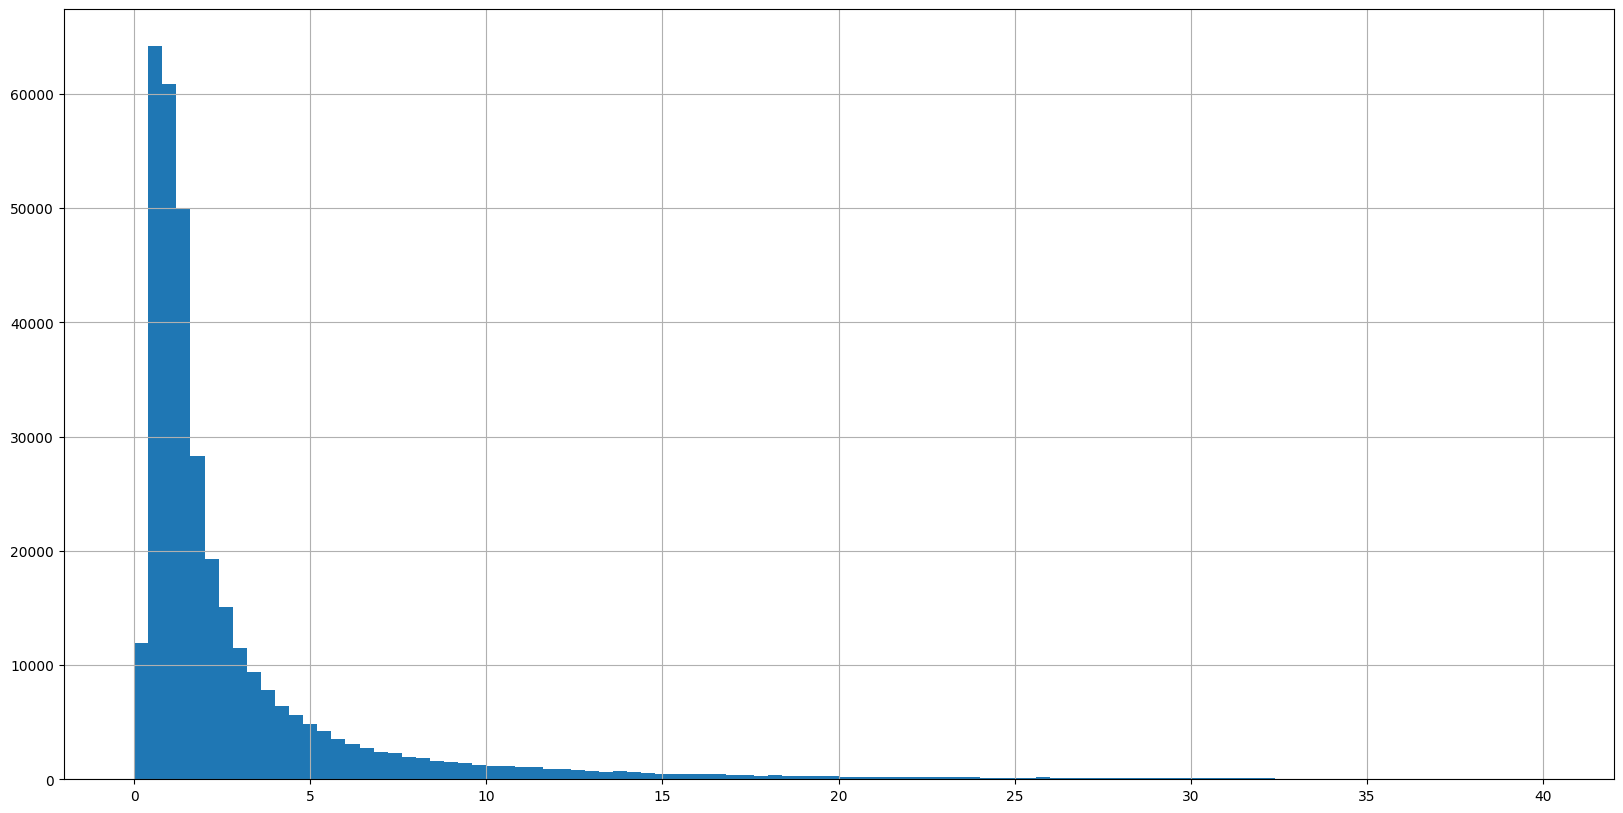

In [48]:
# Print the first 5 rows
#print(df.head())

# Show some examples of movies with a popularity between 0 and 5, sorted by popularity
print(df[(df['popularity'] >= 25) & (df['popularity'] < 30)].sort_values(by='popularity', ascending=False).head())

# Make an histogram of the 'popularity' column, with 100 bins, with an interval of 5 ([0, 5[, [5, 10[, [10, 15[, etc.)])
df['popularity'].hist(bins=100, range=(0, 40), figsize=(20, 10))

# Remove movies with a popularity below 20
df = df[df['popularity'] >= 15]

# Remove movies with a budget of 0
df = df[df['budget'] > 0]

# Save the result to './TMDB_all_movies_cleaned_2.csv'
df.to_csv('./TMDB_all_movies_cleaned_2.csv', index=False)


In [49]:
def genre_average_rating(data, top_genres_column):
    def calc(row):
        top_genres = row[top_genres_column]
        ratings = {}
        for genre in top_genres:
            ratings[genre] = data.loc[data['genres'].apply(lambda g: genre in g), 'vote_average'].mean()
        return ratings
    return calc

In [50]:
# Movies data
movies = df[['id', 'title', 'vote_average', 'status', 'release_date', 'budget', 'revenue', 'cast', 'popularity', 'genres', 'production_companies', 'director']]
movies.to_csv('./movies.csv', index=False)

In [51]:
# Actors data
actors_data = df[['id', 'cast', 'vote_average', 'budget', 'revenue', 'genres', 'popularity']]
actors_data['cast'] = actors_data['cast'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
actors_data['genres'] = actors_data['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
actors = actors_data.explode('cast')  # Split the list of actors into rows
actors = actors.rename(columns={'id': 'movie_id', 'cast': 'actor'})

actor_stats = (
    actors.groupby('actor', as_index=False)
    .agg(
        average_budget=('budget', 'mean'),
        average_revenue=('revenue', 'mean'),
        movies_count=('movie_id', 'count'),
        top_genres=('genres', lambda x: pd.Series(x.explode().unique()).value_counts().head(5).index.tolist()),
        popularity_over_time=('popularity', list),
    )
)

actor_stats.to_csv('./actors.csv', index=False)

/tmp/ipykernel_5444/49760351.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors_data['cast'] = actors_data['cast'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
/tmp/ipykernel_5444/49760351.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors_data['genres'] = actors_data['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)


In [ ]:
movies['cast'] = movies['cast'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
movies['genres'] = movies['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

movies_exploded = movies.explode('cast').explode('genres')
movies_exploded = movies_exploded.rename(columns={'cast': 'actor', 'genres': 'genre'})

average_genre_rating = (
    movies_exploded.groupby(['actor', 'genre'])
    .agg(average_rating=('vote_average', 'mean'))
    .reset_index()
)

average_genre_rating['average_rating'] = average_genre_rating['average_rating'].round(2)

actor_genre_ratings = (
    average_genre_rating.groupby('actor')
    .apply(lambda x: [{'genre': row['genre'], 'average_rating': row['average_rating']} for _, row in x.iterrows()])
    .reset_index(name='genre_ratings')
)

actor_stats.to_csv('./actors.csv', index=False)
movies_with_actor_ratings = pd.merge(
    movies_exploded[['actor']].drop_duplicates(), 
    actor_genre_ratings, 
    on='actor', 
    how='left'
)

movies_with_actor_ratings.to_csv('./actors_with_genre_ratings.csv', index=False)

/tmp/ipykernel_5444/964385379.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: [{'genre': row['genre'], 'average_rating': row['average_rating']} for _, row in x.iterrows()])


In [53]:
# Directors data
directors_data = df[['id', 'director', 'vote_average', 'budget', 'revenue', 'genres', 'popularity']]
directors_data['director'] = directors_data['director'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
directors_data['genres'] = directors_data['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
directors = directors_data.explode('director')  # Explode to get one director per row
directors = directors.rename(columns={'id': 'movie_id', 'director': 'director_name'})

director_stats = (
    directors.groupby('director_name')
    .agg(
        average_budget=('budget', 'mean'),
        average_revenue=('revenue', 'mean'),
        movies_count=('movie_id', 'count'),
        top_genres=('genres', lambda x: pd.Series(x.explode().unique()).value_counts().head(5).index.tolist()),
        popularity_over_time=('popularity', list)
    )
    .reset_index()
)

director_stats.to_csv('./directors.csv', index=False)


/tmp/ipykernel_5444/767172204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  directors_data['director'] = directors_data['director'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
/tmp/ipykernel_5444/767172204.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  directors_data['genres'] = directors_data['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)


In [ ]:
movies['director'] = movies['director'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
movies['genres'] = movies['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

movies_exploded = movies.explode('director').explode('genres')
movies_exploded = movies_exploded.rename(columns={'director': 'director_name', 'genres': 'genre'})

average_genre_rating = (
    movies_exploded.groupby(['director_name', 'genre'])
    .agg(average_rating=('vote_average', 'mean'))
    .reset_index()
)

average_genre_rating['average_rating'] = average_genre_rating['average_rating'].round(2)

director_genre_ratings = (
    average_genre_rating.groupby('director_name')
    .apply(lambda x: [{'genre': row['genre'], 'average_rating': row['average_rating']} for _, row in x.iterrows()])
    .reset_index(name='genre_ratings')
)

movies_with_director_ratings = pd.merge(
    movies_exploded[['director_name']].drop_duplicates(), 
    director_genre_ratings, 
    on='director_name', 
    how='left'
)

movies_with_director_ratings.to_csv('./directors_with_genre_ratings.csv', index=False)

/tmp/ipykernel_5444/1975810683.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: [{'genre': row['genre'], 'average_rating': row['average_rating']} for _, row in x.iterrows()])
